In [43]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil
import glob
import numpy as np


In [4]:
img_size = 640
epochs = 50
batch_size=16
patience = 5

In [5]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17269 (from 2)
Receiving objects: 100% (17270/17270), 16.10 MiB | 27.70 MiB/s, done.
Resolving deltas: 100% (11855/11855), done.


In [6]:
%cd yolov5
!pip install -r requirements.txt

/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [7]:
# Paths
dataset_path = "/kaggle/input/dog-and-cat-detection"
images_path = "/kaggle/input/dog-and-cat-detection/images"
annotations_path = "/kaggle/input/dog-and-cat-detection/annotations"

selected_images_path = "/kaggle/working/selected_images"
selected_annotations_path = "/kaggle/working/selected_annotations"
os.makedirs(selected_images_path, exist_ok=True)
os.makedirs(selected_annotations_path, exist_ok=True)

image_files = sorted(glob.glob(os.path.join(images_path, "*.png")))[:500]  
for img_file in image_files:
    shutil.copy(img_file, selected_images_path)

annot_files = sorted(glob.glob(os.path.join(annotations_path, "*.xml")))[:500]
for annot_file in annot_files:
    shutil.copy(annot_file, selected_annotations_path)

In [8]:
# Define object classes
class_mapping = {"dog": 0, "cat": 1}

# Create YOLO annotations folder
yolo_labels_path = "/kaggle/working/yolo_labels"
os.makedirs(yolo_labels_path, exist_ok=True)

def convert_annotation(xml_file, output_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    image_name = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)
    
    yolo_annotations = []
    
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_mapping:
            continue
        class_id = class_mapping[class_name]
        
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        
        # Convert to YOLO format
        x_center = (xmin + xmax) / (2.0 * width)
        y_center = (ymin + ymax) / (2.0 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height
        
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")
    
    # Save the YOLO annotation
    txt_filename = os.path.join(output_dir, image_name.replace(".png", ".txt"))
    with open(txt_filename, "w") as f:
        f.write("\n".join(yolo_annotations))

xml_files = [os.path.join(selected_annotations_path, f) for f in os.listdir(selected_annotations_path) if f.endswith(".xml")]

for xml_file in xml_files:
    convert_annotation(xml_file, yolo_labels_path)

In [9]:
images_path = "/kaggle/working/selected_images"
annotations_path = "/kaggle/working/selected_annotations"

In [10]:
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith(".png")]

train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)

# Create directories
train_dir = "/kaggle/working/dataset/train/images"
val_dir = "/kaggle/working/dataset/val/images"
train_labels_dir = "/kaggle/working/dataset/train/labels"
val_labels_dir = "/kaggle/working/dataset/val/labels"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)


for file in train_files:
    shutil.copy(file, train_dir)
    label_file = os.path.join(yolo_labels_path, os.path.basename(file).replace(".png", ".txt"))
    if os.path.exists(label_file):
        shutil.copy(label_file, train_labels_dir)

for file in val_files:
    shutil.copy(file, val_dir)
    label_file = os.path.join(yolo_labels_path, os.path.basename(file).replace(".png", ".txt"))
    if os.path.exists(label_file):
        shutil.copy(label_file, val_labels_dir)


In [11]:
data_yaml = """
train: /kaggle/working/dataset/train/images
val: /kaggle/working/dataset/val/images
nc: 2
names: ['dog', 'cat']
"""

with open("/kaggle/working/dataset/data.yaml", "w") as f:
    f.write(data_yaml)


In [12]:
loss_file = "/kaggle/working/yolov5/utils/loss.py"

with open(loss_file, "r") as f:
    lines = f.readlines()

# Replace CIoU with standard IoU
with open(loss_file, "w") as f:
    for line in lines:
        if "CIoU=True" in line:  # Find where CIoU is used
            f.write(line.replace("CIoU=True", "CIoU=False"))  
        else:
            f.write(line)


In [13]:
# Check if the change was applied
with open(loss_file, "r") as f:
    for line in f.readlines():
        if "bbox_iou" in line:
            print(line.strip())  


from utils.metrics import bbox_iou
iou = bbox_iou(pbox, tbox[i], CIoU=False).squeeze()  # iou(prediction, target)


In [17]:
%cd /kaggle/working/yolov5
!python train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/dataset/data.yaml --weights yolov5s.pt --patience 5

/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-16 02:43:56.499672: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-16 02:43:56.521212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-16 02:43:56.527817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account

In [22]:
import pandas as pd

results_df = pd.read_csv("runs/train/exp/results.csv")

print("Final YOLOv5 Metrics:")
print(results_df.tail(1))


Final YOLOv5 Metrics:
                   epoch        train/box_loss        train/obj_loss  \
21                    21              0.029771              0.011946   

          train/cls_loss     metrics/precision        metrics/recall  \
21              0.004979               0.95183               0.89037   

         metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
21               0.92553               0.68557              0.020028   

            val/obj_loss          val/cls_loss                 x/lr0  \
21              0.005783              0.004762               0.00604   

                   x/lr1                 x/lr2  
21               0.00604               0.00604  


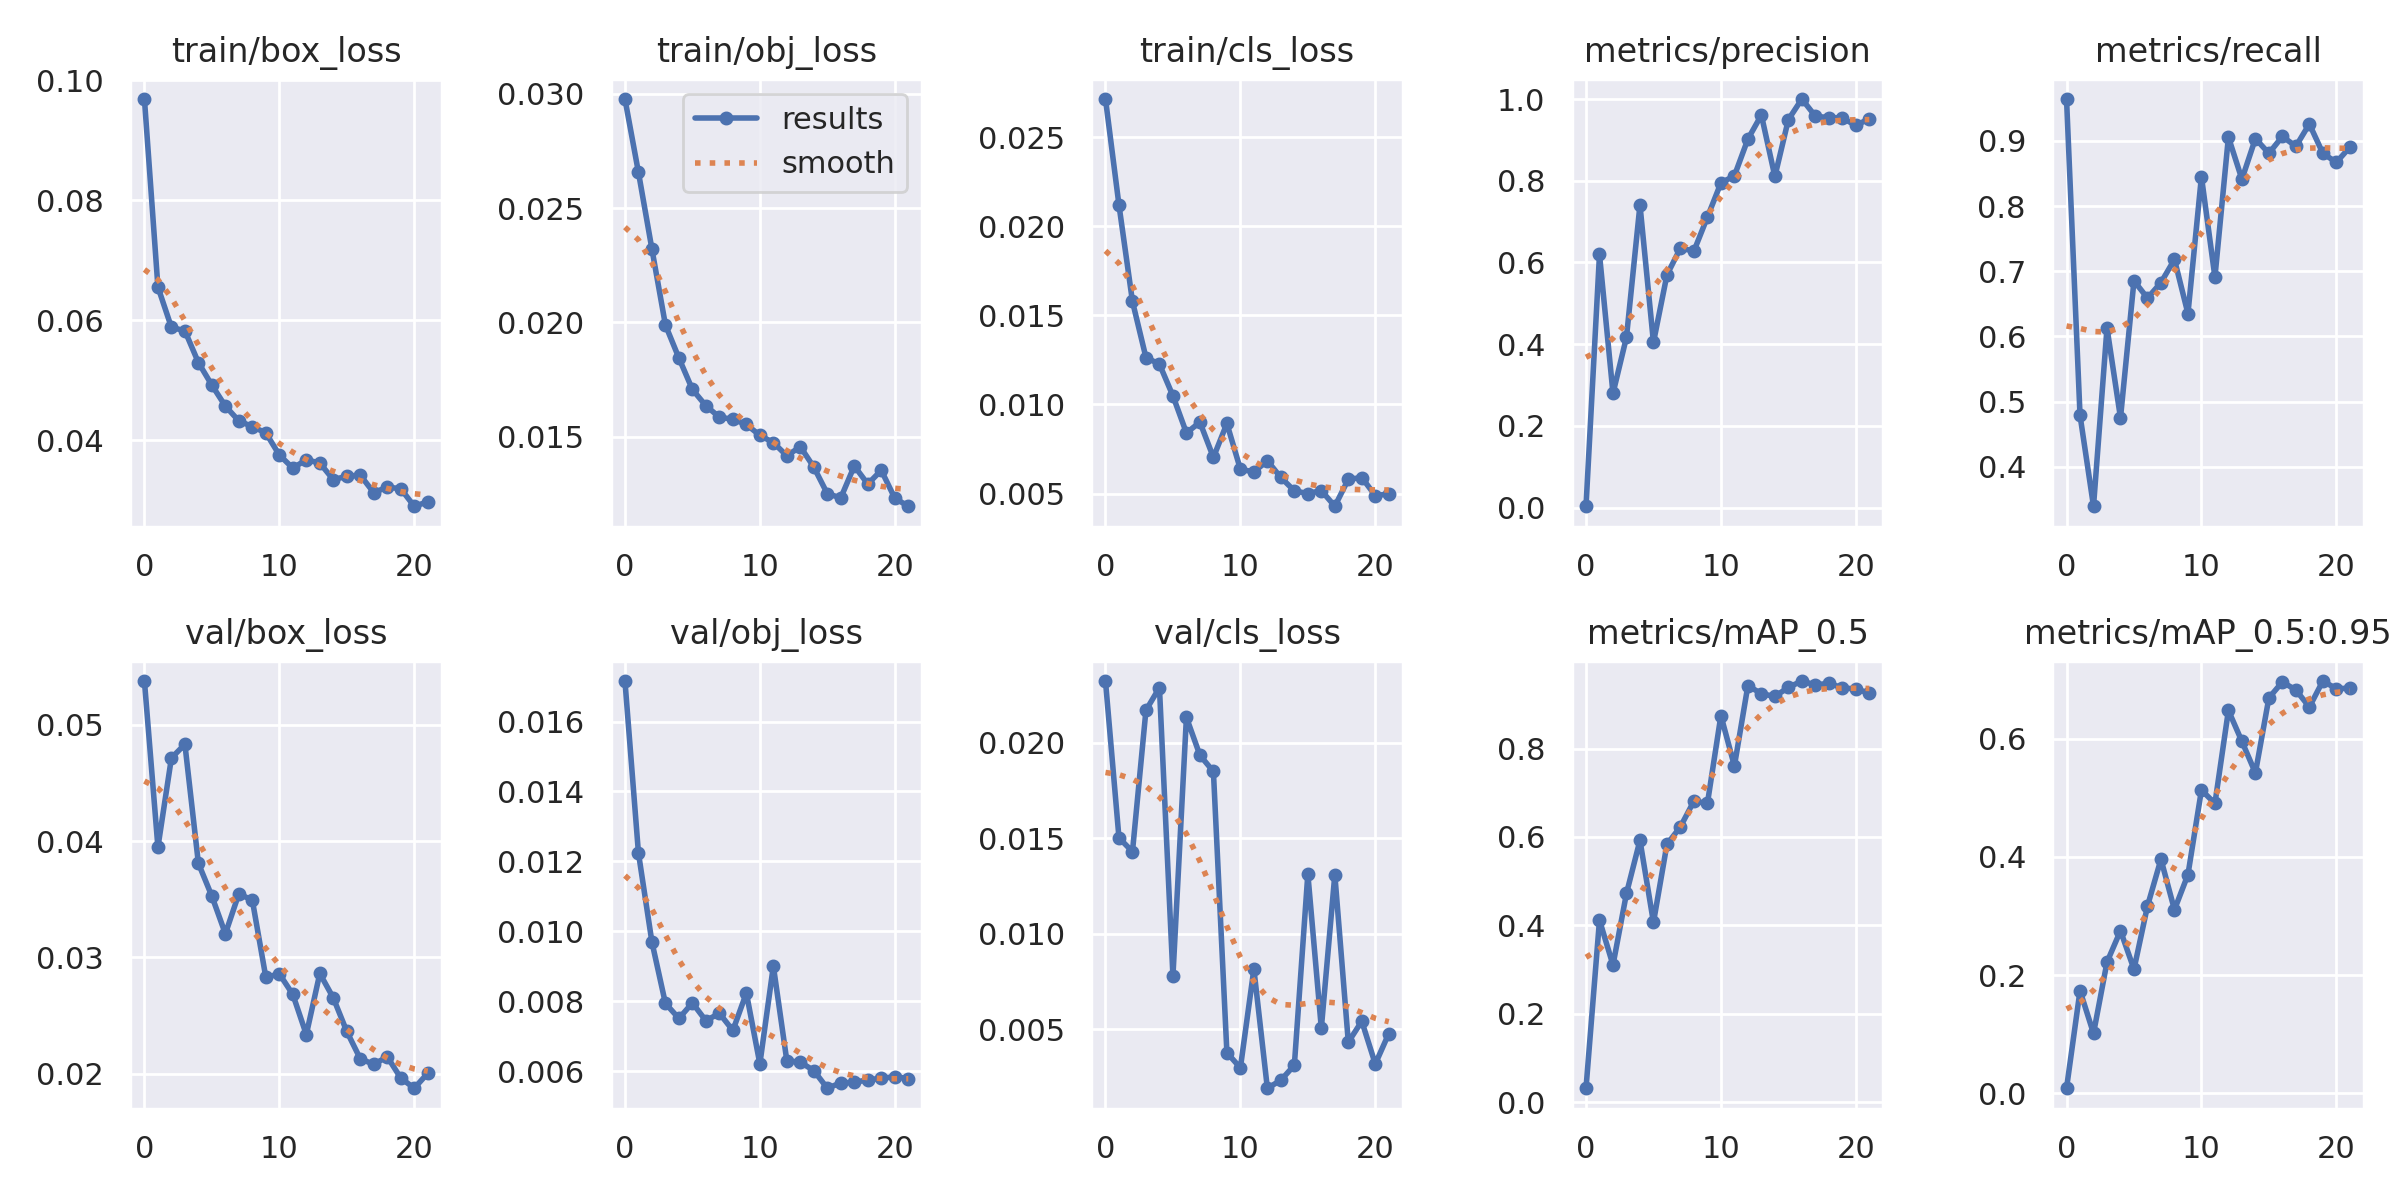

In [19]:
from IPython.display import Image
Image(filename='runs/train/exp/results.png')


In [23]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.4 --source /kaggle/working/dataset/val/images/ --save-txt --save-conf

detect: weights=['runs/train/exp/weights/best.pt'], source=/kaggle/working/dataset/val/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-398-g5cdad892 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/50 /kaggle/working/dataset/val/images/Cats_Test1.png: 640x640 1 dog, 11.4ms
image 2/50 /kaggle/working/dataset/val/images/Cats_Test100.png: 480x640 (no detections), 29.0ms
image 3/50 /kaggle/working/dataset/val/images/Cats_Test1013.png: 480x640 1 dog, 9.1ms
image 4/50 /kaggle/working/dataset/

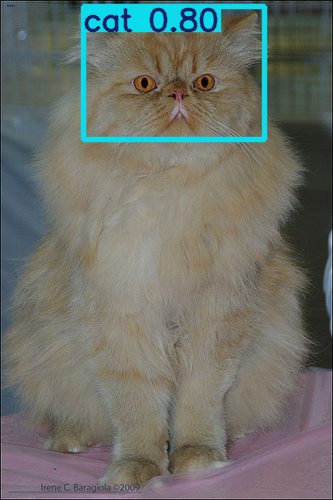

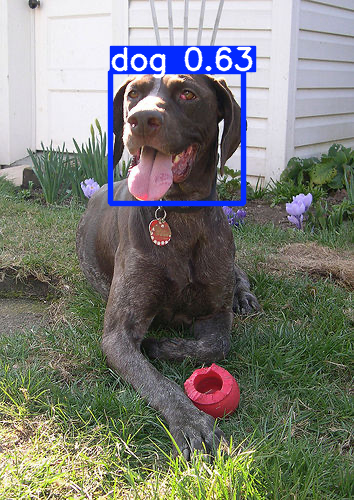

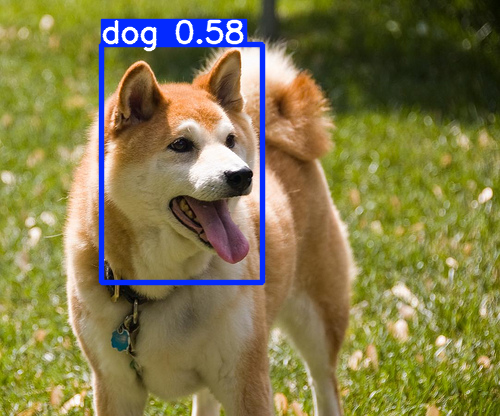

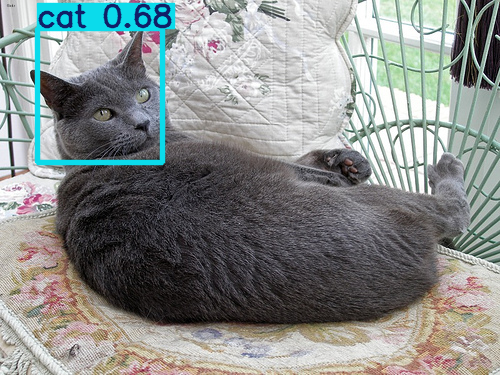

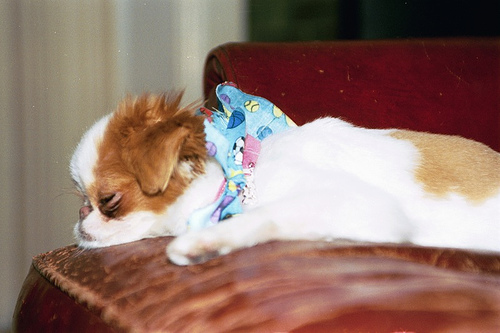

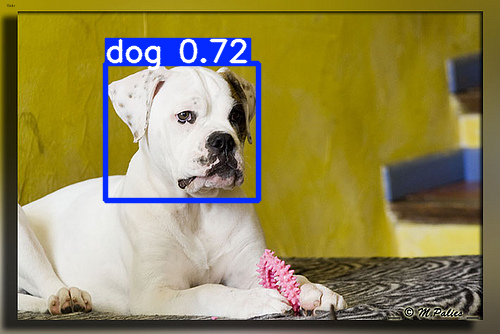

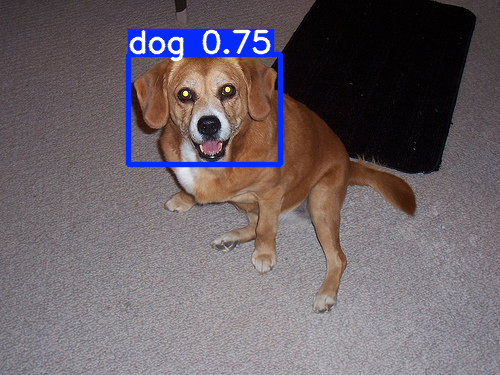

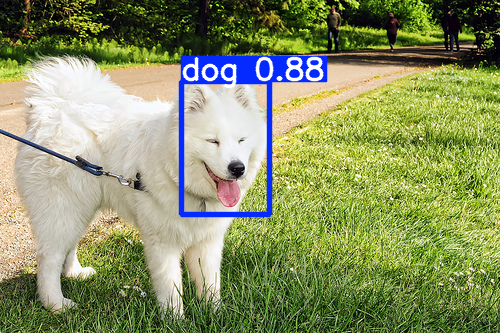

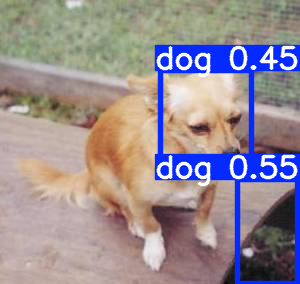

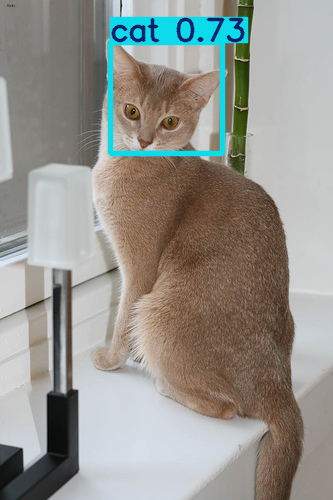

In [25]:
from IPython.display import display
from PIL import Image

result_images = glob.glob("runs/detect/exp/*.png")

for img_path in result_images[:10]:
    display(Image.open(img_path))


In [32]:
def convert_to_corners(box):
    """
    Converts (cx, cy, w, h) to (xmin, ymin, xmax, ymax)
    """
    cx, cy, w, h = box
    xmin = cx - w / 2
    ymin = cy - h / 2
    xmax = cx + w / 2
    ymax = cy + h / 2
    return [xmin, ymin, xmax, ymax]


In [38]:
def compute_iou(box1, box2):
    b1 = convert_to_corners(box1)
    b2 = convert_to_corners(box2)

    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (b1[2] - b1[0]) * (b1[3] - b1[1])
    box2_area = (b2[2] - b2[0]) * (b2[3] - b2[1])
    
    return inter_area / (box1_area + box2_area - inter_area + 1e-6)

def compute_giou(box1, box2):
    b1 = convert_to_corners(box1)
    b2 = convert_to_corners(box2)

    iou = compute_iou(box1, box2)
    
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])
    
    xC = min(b1[0], b2[0])
    yC = min(b1[1], b2[1])
    xD = max(b1[2], b2[2])
    yD = max(b1[3], b2[3])
    
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    enclosing_area = (xD - xC) * (yD - yC)
    return iou - (enclosing_area - (b1[2] - b1[0]) * (b1[3] - b1[1]) - (b2[2] - b2[0]) * (b2[3] - b2[1]) + inter_area) / enclosing_area

def compute_diou(box1, box2):
    iou = compute_iou(box1, box2)

    # Extract center points
    c1 = np.array([box1[0], box1[1]])
    c2 = np.array([box2[0], box2[1]])
    dist = np.linalg.norm(c1 - c2)

    b1 = convert_to_corners(box1)
    b2 = convert_to_corners(box2)
    xC = min(b1[0], b2[0])
    yC = min(b1[1], b2[1])
    xD = max(b1[2], b2[2])
    yD = max(b1[3], b2[3])
    diag = np.linalg.norm([xD - xC, yD - yC])

    return iou - (dist ** 2 / (diag ** 2 + 1e-6))

def compute_ciou(box1, box2):
    iou = compute_iou(box1, box2)
    diou = compute_diou(box1, box2)

    w1, h1 = box1[2], box1[3]
    w2, h2 = box2[2], box2[3]

    v = (4 / (np.pi ** 2)) * (np.arctan(w1 / h1) - np.arctan(w2 / h2)) ** 2
    alpha = v / (1 - iou + v + 1e-6)

    return diou - alpha * v


In [39]:
predicted_labels_path = "runs/detect/exp/labels/"
predicted_files = os.listdir(predicted_labels_path)

predictions = {}

for file in predicted_files:
    img_name = file.replace(".txt", ".png")  # Match image names
    with open(os.path.join(predicted_labels_path, file), "r") as f:
        detections = [list(map(float, line.strip().split())) for line in f.readlines()]
    predictions[img_name] = detections

In [40]:
ground_truth_path = "/kaggle/working/dataset/val/labels/"
ground_truth_files = os.listdir(ground_truth_path)

ground_truth = {}

for file in ground_truth_files:
    img_name = file.replace(".txt", ".png")  # Match image names
    with open(os.path.join(ground_truth_path, file), "r") as f:
        annotations = [list(map(float, line.strip().split())) for line in f.readlines()]
    ground_truth[img_name] = annotations


In [30]:
ground_truth["Cats_Test1.png"]

[[0.0, 0.368, 0.244, 0.224, 0.4]]

In [31]:
predictions["Cats_Test1.png"]

[[0.0, 0.371, 0.238, 0.21, 0.296, 0.726952]]

In [51]:
def customized_similarity(box1, box2):
    
    def center_distance(b1, b2):
        """ Computes normalized center distance """
        c1 = np.array([b1[0], b1[1]])
        c2 = np.array([b2[0], b2[1]])
        dist = np.linalg.norm(c1 - c2)

        max_dim = max(b1[2], b1[3], b2[2], b2[3])  
        return dist / max_dim  

    def aspect_ratio_similarity(b1, b2):
        """ Computes aspect ratio similarity """
        ar1 = b1[2] / b1[3]  # width/height
        ar2 = b2[2] / b2[3]
        return min(ar1, ar2) / max(ar1, ar2)

    def size_similarity(b1, b2):
        """ Computes size similarity based on area """
        area1 = b1[2] * b1[3]
        area2 = b2[2] * b2[3]
        return min(area1, area2) / max(area1, area2)

    iou = compute_iou(box1, box2)
    d = center_distance(box1, box2)
    ar_sim = aspect_ratio_similarity(box1, box2)
    size_sim = size_similarity(box1, box2)

    similarity = (0.25*iou) + (0.25*(1 - d)) + (0.25*ar_sim) + (0.25*size_sim)
    return similarity


In [52]:
iou_scores = []
giou_scores = []
diou_scores = []
ciou_scores = []
cst_scores = []

iou_threshold = 0.5  
for img_name, gt_boxes in ground_truth.items():
    pred_boxes = predictions.get(img_name, [])

    matched_gt = set()
    matched_pred = set()

    for p_idx, p_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        best_metrics = {}

        for g_idx, g_box in enumerate(gt_boxes):
            p_coords = p_box[1:5]
            g_coords = g_box[1:5]

            iou = compute_iou(p_coords, g_coords)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = g_idx

                
                best_metrics["iou"] = iou
                best_metrics["giou"] = compute_giou(p_coords, g_coords)
                best_metrics["diou"] = compute_diou(p_coords, g_coords)
                best_metrics["ciou"] = compute_ciou(p_coords, g_coords)
                best_metrics["custom"] = customized_similarity(p_coords, g_coords)

        if best_iou >= iou_threshold:
            matched_gt.add(best_gt_idx)
            matched_pred.add(p_idx)

            iou_scores.append(best_metrics["iou"])
            giou_scores.append(best_metrics["giou"])
            diou_scores.append(best_metrics["diou"])
            ciou_scores.append(best_metrics["ciou"])
            cst_scores.append(best_metrics["custom"])

mean_iou = np.mean(iou_scores) if iou_scores else 0
mean_giou = np.mean(giou_scores) if giou_scores else 0
mean_diou = np.mean(diou_scores) if diou_scores else 0
mean_ciou = np.mean(ciou_scores) if ciou_scores else 0
mean_cst = np.mean(cst_scores) if cst_scores else 0

print("\nAverage Similarity Scores:")
print(f"IoU:  {mean_iou:.4f}")
print(f"GIoU: {mean_giou:.4f}")
print(f"DIoU: {mean_diou:.4f}")
print(f"CIoU: {mean_ciou:.4f}")
print(f"Customized:  {mean_cst:.4f}")



Average Similarity Scores:
IoU:  0.8498
GIoU: 0.8476
DIoU: 0.8485
CIoU: 0.8485
Customized:  0.9084


In [61]:
correct_detections = {"IoU": [], "GIoU": [], "DIoU": [], "CIoU": [], "Customized": []}
missed_detections = {"IoU": [], "GIoU": [], "DIoU": [], "CIoU": [], "Customized": []}
false_positives = {"IoU": [], "GIoU": [], "DIoU": [], "CIoU": [], "Customized": []}
unlabeled_images = {"IoU": [], "GIoU": [], "DIoU": [], "CIoU": [], "Customized": []}

iou_threshold = 0.5  # Detection threshold

similarity_metrics = {
    "IoU": compute_iou,
    "GIoU": compute_giou,
    "DIoU": compute_diou,
    "CIoU": compute_ciou,
    "Customized": customized_similarity,
}

for metric_name, similarity_function in similarity_metrics.items():
    for img_name, gt_boxes in ground_truth.items():
        pred_boxes = predictions.get(img_name, [])
        
        matched_gt = set()
        matched_pred = set()

        for p_idx, p_box in enumerate(pred_boxes):
            best_score = 0
            best_gt_idx = -1

            for g_idx, g_box in enumerate(gt_boxes):
                score = similarity_function(p_box[1:5], g_box[1:5])  # Ignore class ID
                if score > best_score:
                    best_score = score
                    best_gt_idx = g_idx

            if best_score >= iou_threshold:
                correct_detections[metric_name].append(img_name)
                matched_gt.add(best_gt_idx)
                matched_pred.add(p_idx)
            else:
                false_positives[metric_name].append(img_name)

        for g_idx in range(len(gt_boxes)):
            if g_idx not in matched_gt:
                missed_detections[metric_name].append(img_name)

    for img_name in predictions.keys():
        if img_name not in ground_truth:
            unlabeled_images[metric_name].append(img_name)

for metric_name in similarity_metrics.keys():
    correct_detections[metric_name] = list(set(correct_detections[metric_name]))
    missed_detections[metric_name] = list(set(missed_detections[metric_name]))
    false_positives[metric_name] = list(set(false_positives[metric_name]))
    unlabeled_images[metric_name] = list(set(unlabeled_images[metric_name]))

for metric_name in similarity_metrics.keys():
    print(f"\n {metric_name} Performance:")
    print(f"Correct Detections: {len(correct_detections[metric_name])}")
    print(f"Missed Detections: {len(missed_detections[metric_name])}")
    print(f"False Positives: {len(false_positives[metric_name])}")
    print(f"Unlabeled Images: {len(unlabeled_images[metric_name])}")



 IoU Performance:
Correct Detections: 40
Missed Detections: 10
False Positives: 1
Unlabeled Images: 0

 GIoU Performance:
Correct Detections: 39
Missed Detections: 11
False Positives: 1
Unlabeled Images: 0

 DIoU Performance:
Correct Detections: 39
Missed Detections: 11
False Positives: 1
Unlabeled Images: 0

 CIoU Performance:
Correct Detections: 39
Missed Detections: 11
False Positives: 1
Unlabeled Images: 0

 Customized Performance:
Correct Detections: 40
Missed Detections: 10
False Positives: 1
Unlabeled Images: 0
